In [180]:
from torch import tensor
from fft_conv import fft_conv

step = 5

a = tensor([1, 2, 3, 4], dtype=torch.float64)
b = tensor([1, 1, 0, 1], dtype=torch.float64)
w = tensor([step] * len(a), dtype=torch.float64)
w[0], w[-1] = step * 0.5, step * 0.5

(w * b) @ a

tensor(22.5000, dtype=torch.float64)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simpson
from fft_conv import fft_conv
import torch
import torch.nn.functional as f

In [233]:
graph = make_dot(Q, params={'x': solver.x})

In [234]:
graph.view()

'Digraph.gv.pdf'

In [352]:
import numpy as np
import torch
from torch import Tensor
import torch.nn.functional as f
from fft_conv import fft_conv
from scipy.stats import norm

class Neumann:
    EPS = 1e-12

    def _calc_step(self):
        sqrt2pi = (2 * np.pi) ** 0.5
        logm = np.log(self.EPS * self.sm * sqrt2pi)
        logw = np.log(self.EPS * self.sw * sqrt2pi)

        if logm > 0 or logw > 0:
            t = 1
        else:
            xm = np.sqrt(-2 * (self.sm ** 2) * logm)
            xw = np.sqrt(-2 * (self.sw ** 2) * logw)
            t = max(xm, xw)

        return t / len(self.GT)
    
    def _calc_disribution(self, sigma):
        lspace = np.linspace(0, self.r, len(self.GT))
        return torch.tensor(norm.pdf(lspace, scale=sigma))
    
    def __init__(self, GT, sm, sw, b, d, s, x0, r=15, n_iters=15):
        # save params
        self.n_iters = n_iters
        self.r = r
        
        self.b = b
        self.d = d
        self.s = s
        self.sm = sm
        self.sw = sw
        
        self.GT = torch.from_numpy(GT)
        
        # init m, w
        self.m = self._calc_disribution(sm) * self.b
        self.w = self._calc_disribution(sw) * self.s
        
        # step
        self.step = self._calc_step()
        
        #parameters to optimize
        self.x = torch.tensor(x0, requires_grad=True)
        
        self.lr = 0.1
        
        
    def _scalar_product(self, f: Tensor, g: Tensor) -> Tensor:
        w = torch.tensor([self.step] * len(self.GT), dtype=torch.double)
        w[0], w[-1] = [self.step * 0.5] * 2
        return 2 * f @ (w * g)
    
    def _get_convolutions(self, signal: Tensor, kernel: Tensor) -> Tensor:
        f = torch.reshape(signal, [1, 1, signal.size(-1)])
        g = torch.reshape(kernel, [1, 1, kernel.size(-1)])
        window_start = (f.size(-1)+1) // 2
        res = fft_conv(f, g, padding=f.size(-1) - 1)[..., window_start:window_start + f.size(-1)]
        res = torch.reshape(res, [f.size(-1)])
        return res * self.step / f.size(-1)
        
    def _convolve(self, C: Tensor) -> (Tensor, Tensor, Tensor):
        mC = self._get_convolutions(C, self.m)
        wC = self._get_convolutions(C, self.w)
        CwC = self._get_convolutions(C, self.w*C)
        return mC, wC, CwC

    def _neumann_iteration(self, N: Tensor, C: Tensor) -> (Tensor, Tensor):
        Y = self._scalar_product(C, self.w)
        N = (self.b - self.d) / (Y + self.s)
        mC, wC, CwC = self._convolve(C)
        C = (self.m / N - self.w + mC - N / (self.x[0] + self.x[2]) * (wC * (self.x[1] * (C + 1) + self.x[2]) + CwC * self.x[2])) / \
            (self.d + self.w + (self.x[0] * (self.b - self.d) + self.x[1] * self.s * N) / (self.x[0] + self.x[2]))
        return N, C
    def method(self) -> (Tensor, Tensor, Tensor, Tensor):
        C = self.w.clone().detach()
        N = torch.tensor([1.], requires_grad=False, dtype=torch.double)
        for i in range(self.n_iters):
            N, C = self._neumann_iteration(N, C)
        C += 1
        Q = torch.norm(C - self.GT)**2
        return N, C, Q, self.x
    def proj_grad(self) -> Tensor:
        t = torch.ones(len(self.x), dtype=torch.double, requires_grad=False)
        norms = []
        for i in range(500):
            N, C, Q, x = self.method()
            Q.backward()
            with torch.no_grad():
                x -= self.lr * self.x.grad / torch.norm(self.x.grad)
                self.x.grad = None
            self.x = (x + (1 - x @ t) / 3 * t).clone().detach().requires_grad_(True)
            norms.append(Q.detach().numpy())
            if (i % 500 == 0):
                print(f"Q:{Q}, current x:{self.x}")
        return self.x, norms
        

In [328]:
sims = pd.read_csv(f'./GT/pcf/{1}/{1}.csv').fillna(method='bfill')
sms = np.array([0.96, 0.45, 0.09])
sws = np.array([0.09, 0.45, 0.96])
b = 0.2
d = 0.02
dds = np.array([0.02, 0.2, 0.4])
x0 = np.array([1.0, 1.0, -3.0])

In [353]:
solver = Neumann(np.array(sims['y']), sms[0], sws[0], b, d, dds[0], x0)

In [302]:
N, C, Q, new_x = solver.method()

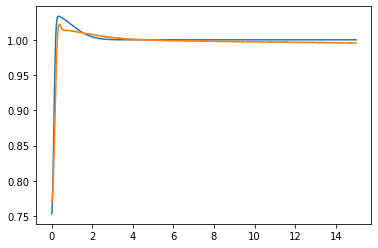

In [304]:
plt.plot(lspace, C.detach().numpy())
plt.plot(lspace, sims['y'])

In [354]:
x, norms = solver.proj_grad()

Q:15.529631153713309, current x:tensor([ 1.6998,  1.6467, -2.3465], dtype=torch.float64, requires_grad=True)


In [355]:
norms = np.array(norms)
norms.shape

(500,)

In [356]:
%config InlineBackend.figure_format = 'retina'

In [357]:
def myplot(x, y, xlab, ylab, xscale="linear", yscale="log"):
    plt.figure(figsize=(10, 8))
    plt.xscale(xscale)
    plt.yscale(yscale)
    for key in y:
        plt.semilogy(x[key], y[key], label=key)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(loc="best", fontsize=24)
    plt.xlabel(xlab, fontsize=24)
    plt.ylabel(ylab, fontsize=24)

In [ ]:
np.sqrt()

Относительная погрешность, %: 0.8160478725019593


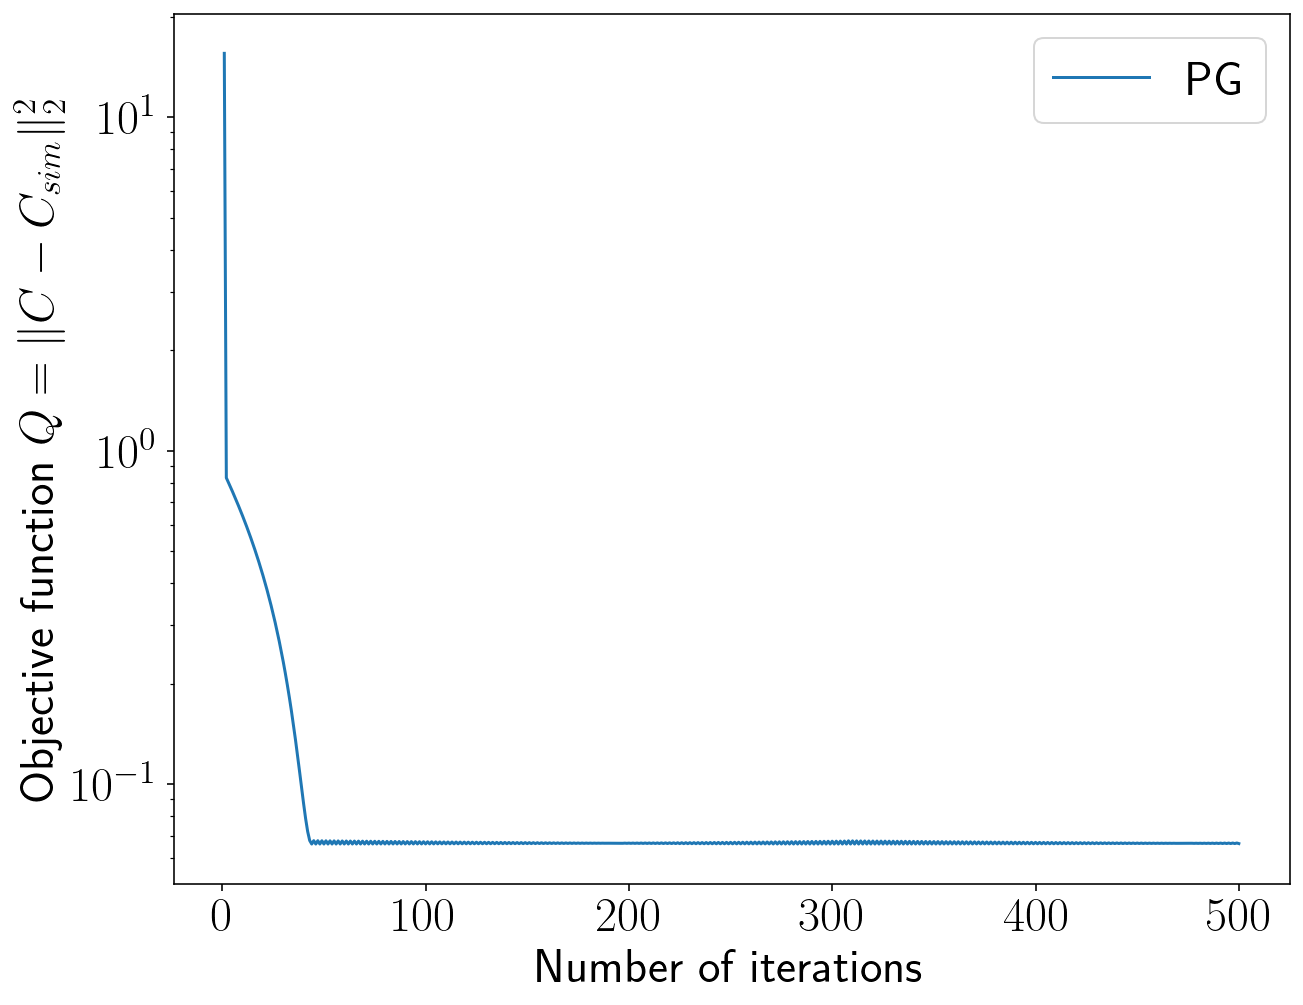

In [367]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
myplot({"PG": range(1, len(norms) + 1)},
       {"PG": norms}, "Number of iterations",
       r"Objective function $Q = \|C - C_{sim}\|^2_2$")
print(f"Относительная погрешность, %: {np.sqrt(norms[-1]) / np.linalg.norm(sims['y']) * 100}")

In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return [result[0:len(result)-1], f"Double_exp: alpha {alpha}, beta {beta}"]


def moving_average(n, p = 96, std = False):
    rolling_mean = sims[index_of_data_set]['pcf'].rolling(window=n).mean()

    if std: # При желании, можно строить и доверительные интервалы для сглаженных значений
        rolling_std =  sims[index_of_data_set]['pcf'].rolling(window=n).std()
        upper_bond = rolling_mean + float(f"1.{p}") * rolling_std
        lower_bond = rolling_mean - 1.96 * rolling_std

    return [rolling_std, lower_bond, upper_bond, std, f"Rolling mean trend n={n}", p]


def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return [result, f"Exp: alpha {alpha}"]

In [1]:
def printer(exp, double_exp, avg):
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(10, 5))
        plt.plot(sims[index_of_data_set]['pcf'], label = "Actual")

        plt.plot(exp[0], label=exp[1])
        plt.plot(double_exp[0], label=double_exp[1])
        plt.plot(avg[0], label=avg[4])
        
        if avg[3]:
            plt.plot(avg[1], "r--")
            plt.plot(avg[2], "r--", label=f"Upper/Lower, {avg[5]}perc")
        
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Smoothing comparison")
        plt.grid(True)
        plt.show()

In [ ]:
data = sims[index_of_data_set]['pcf']

printer(
    exponential_smoothing(data, 0.87),
    double_exponential_smoothing(data, 0.7, 0.3),
    moving_average(5))